# 第十八次课后练习

**负责助教：朱轩宇**

<span style="color:red; font-weight:bold;">请将作业文件命名为 第十八次课后练习+姓名+学号.ipynb, 例如 第十八次课后练习+张三+1000000000.ipynb</span>


<span style="color:red; font-weight:bold;">在作业过程中觉得有心得或者自己拓展学习到有价值内容的，可以在文件名最后加一个#号。例如第十八次课后练习+张三+1000000000+#.ipynb</span>

# 第零部分 代码理解

请认真阅读代码，理解代码的功能，先写出预想的结果。运行并检验结果是否如预期。如果不如预期，请分析理解其中的原因

**RNN 网络与序列编码：预测 AABA 股票数据**

在本笔记本中，我们将使用循环神经网络 (RNN) 对 AABA 股票数据进行建模和预测。我们将处理时间序列数据，构建模型，并可视化收益率。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

**数据加载与预处理**

数据集前5行:
         Date   Open   High    Low  Close    Volume  Name
0  2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1  2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2  2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3  2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4  2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA

数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB
None


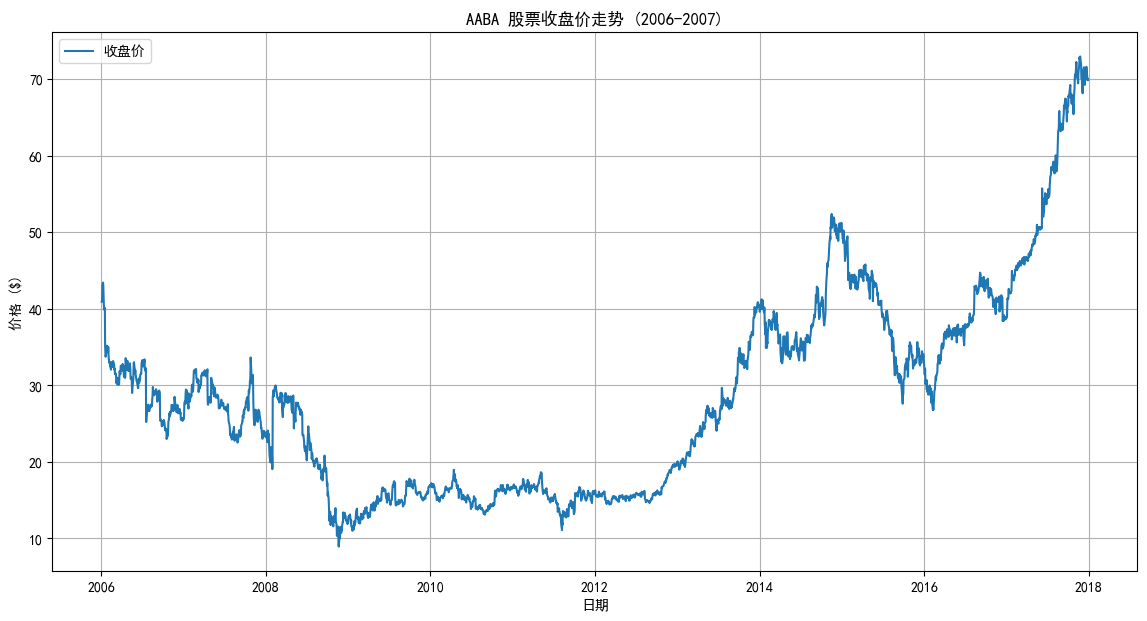


收盘价统计信息:
count    3019.000000
mean       28.412726
std        13.258163
min         8.950000
25%        16.130000
50%        27.100000
75%        36.635000
max        72.930000
Name: Close, dtype: float64


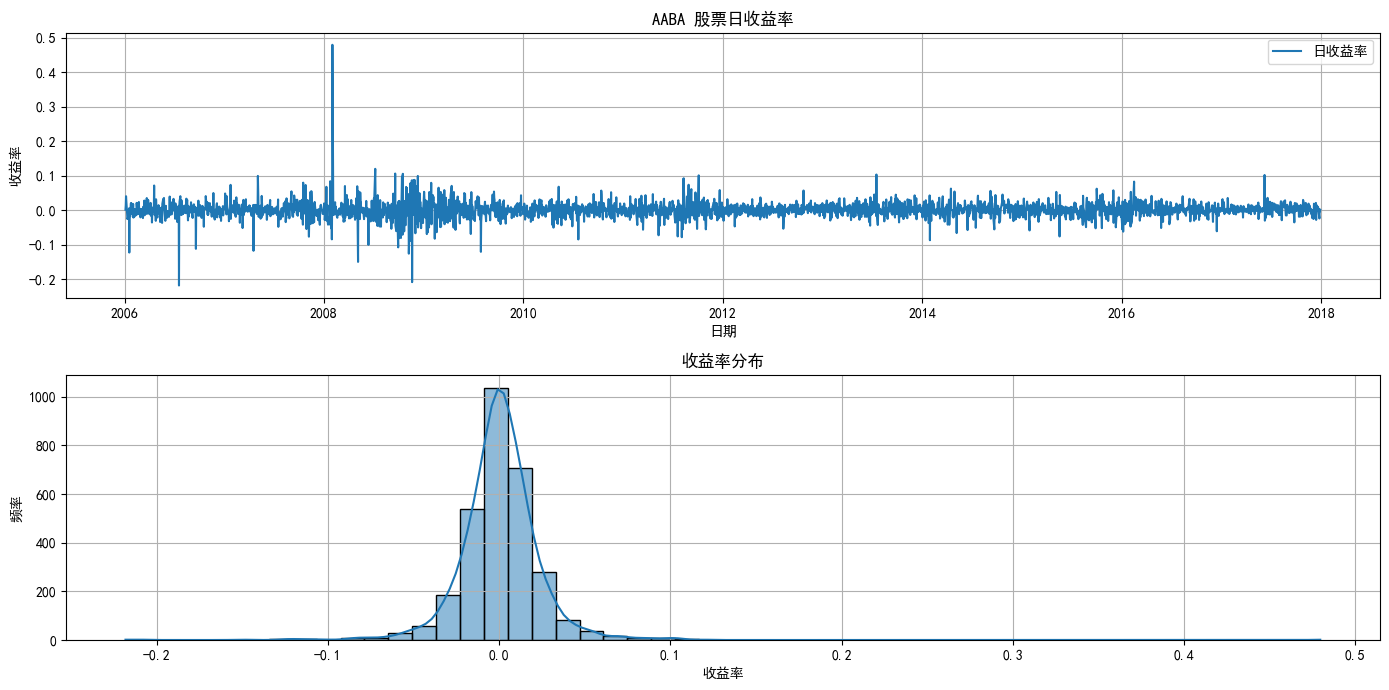

In [ ]:
# 读取数据
df = pd.read_csv('AABA_2006-01-01_to_2018-01-01.csv')

# 查看数据集前几行
print("数据集前5行:")
print(df.head())

# 查看数据基本信息
print("\n数据集信息:")
print(df.info())

# 将日期列转换为日期时间类型
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 数据可视化 - 查看股票价格变动趋势
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='收盘价')
plt.title('AABA 股票收盘价走势 (2006-2007)')
plt.xlabel('日期')
plt.ylabel('价格 ($)')
plt.legend()
plt.grid(True)
plt.show()

# 查看Close的统计信息
print("\n收盘价统计信息:")
print(df['Close'].describe())

# 计算每日收益率
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)

# 绘制收益率分布图
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Returns'], label='日收益率')
plt.title('AABA 股票日收益率')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
sns.histplot(df['Returns'], bins=50, kde=True)
plt.title('收益率分布')
plt.xlabel('收益率')
plt.ylabel('频率')
plt.grid(True)
plt.tight_layout()
plt.show()

"""
注：收益率计算原理：
收益率 = (今日收盘价 - 昨日收盘价) / 昨日收盘价
这是金融分析中常用的指标，反映股票价格的每日变化幅度。
"""

**数据准备与特征构建**

训练集大小: (2414, 5)
测试集大小: (604, 5)

添加特征后的训练集形状: (2395, 17)
添加特征后的测试集形状: (585, 17)

特征列表: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MA20', 'Close_pct_change', 'Open_pct_change', 'HL_diff', 'OC_diff', 'Volatility', 'Volume_pct_change', 'Volume_MA5', 'RSI', 'Momentum']


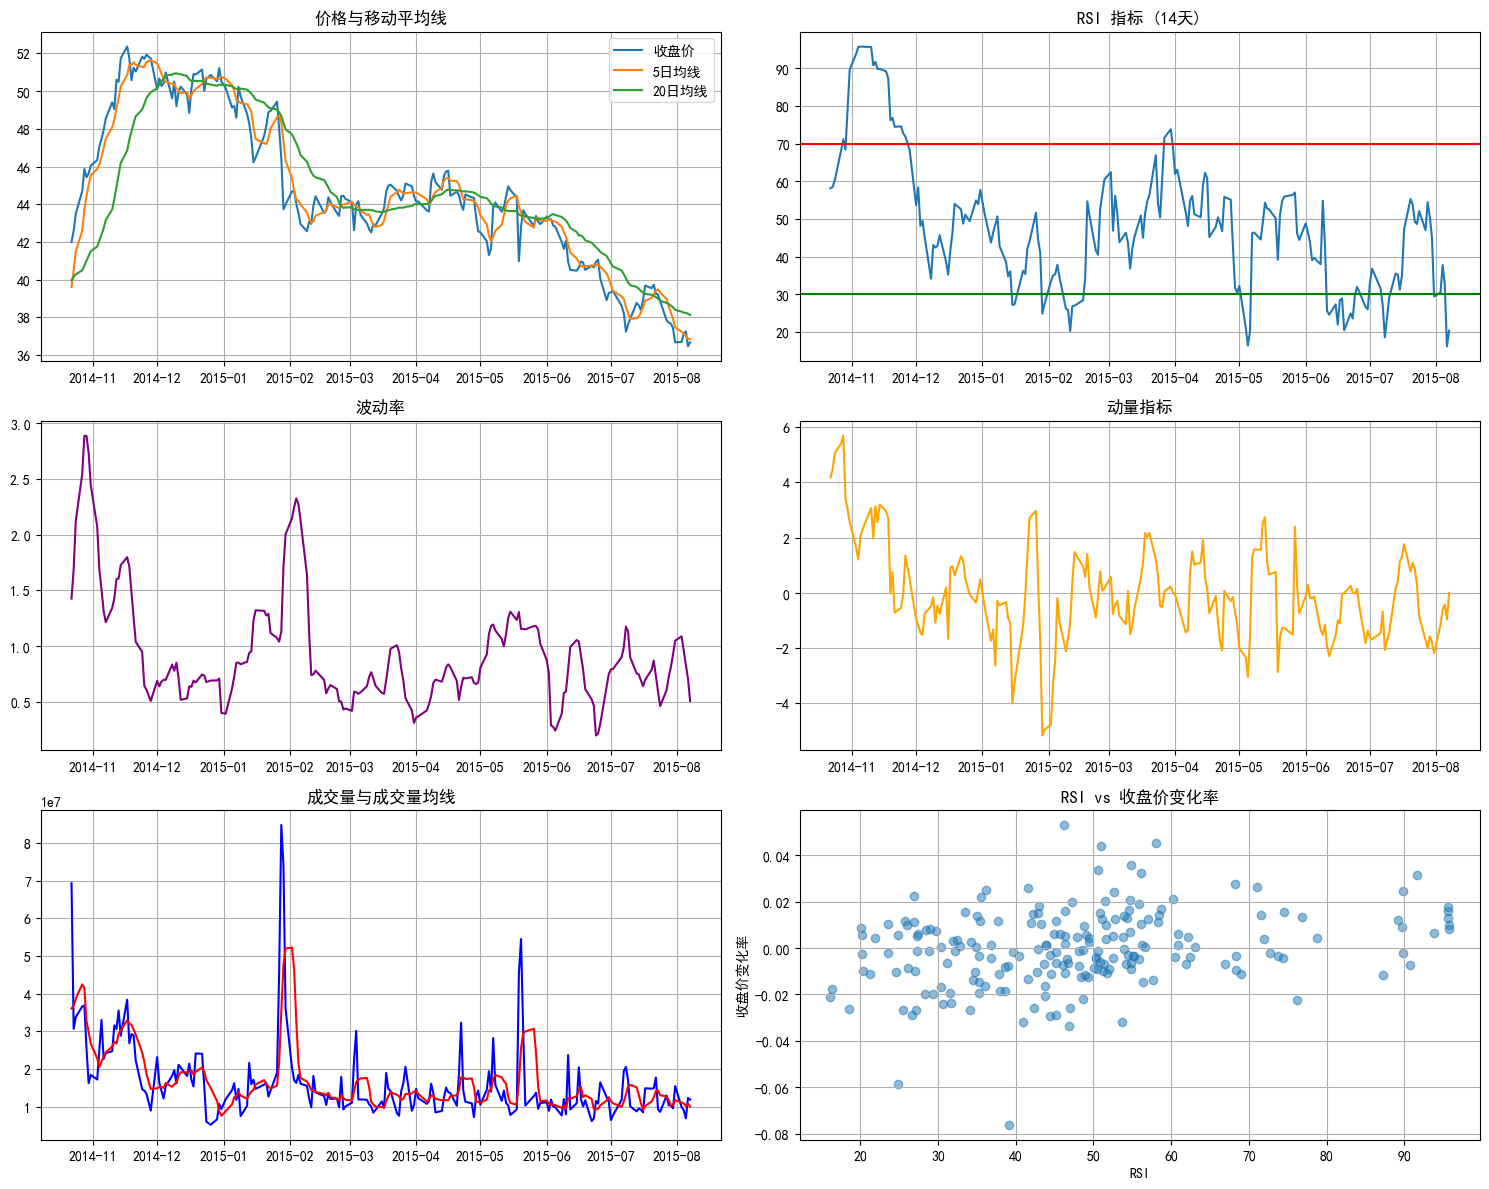

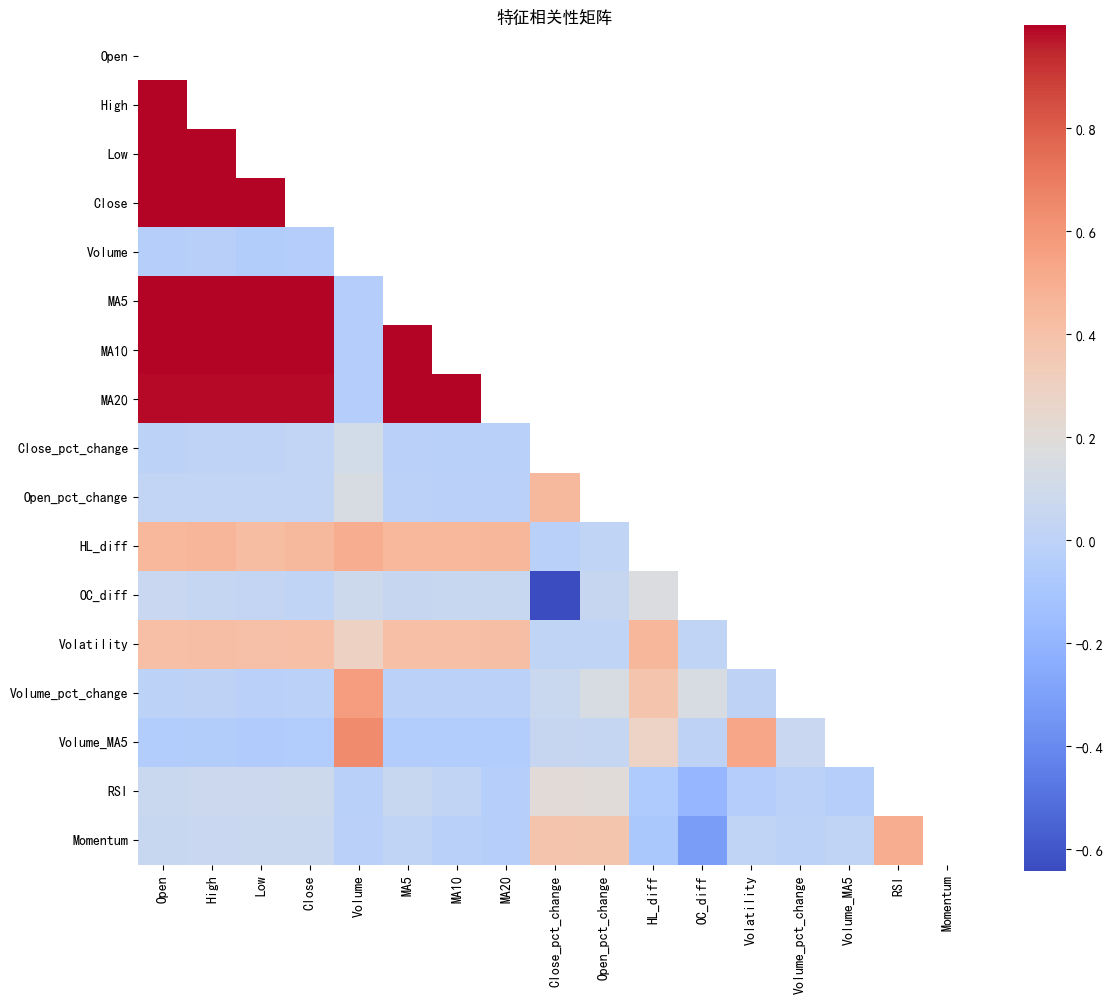


训练集形状: X_train: (2335, 60, 12), y_train: (2335,)
测试集形状: X_test: (525, 60, 12), y_test: (525,)


In [ ]:
# 数据准备与特征构建
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 选择基础特征列
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].copy()

# 首先划分训练集和测试集（避免数据泄露）
split_point = int(len(data) * 0.8)
train_data = data.iloc[:split_point].copy()
test_data = data.iloc[split_point:].copy()

print(f"训练集大小: {train_data.shape}")
print(f"测试集大小: {test_data.shape}")

"""
按8:2的比例划分训练集和测试集
打印训练集和测试集的大小
"""

# 在训练集上构建特征
def add_features(df):
    """为数据集添加技术指标特征"""
    df_new = df.copy()
    
    # 1. 移动平均线特征
    df_new['MA5'] = df_new['Close'].rolling(window=5).mean()
    df_new['MA10'] = df_new['Close'].rolling(window=10).mean()
    df_new['MA20'] = df_new['Close'].rolling(window=20).mean()
    
    # 2. 价格变化率
    df_new['Close_pct_change'] = df_new['Close'].pct_change()
    df_new['Open_pct_change'] = df_new['Open'].pct_change()
    
    # 3. 价格差异特征
    df_new['HL_diff'] = df_new['High'] - df_new['Low']
    df_new['OC_diff'] = df_new['Open'] - df_new['Close']
    
    # 4. 波动率特征
    df_new['Volatility'] = df_new['Close'].rolling(window=10).std()
    
    # 5. 成交量特征
    df_new['Volume_pct_change'] = df_new['Volume'].pct_change()
    df_new['Volume_MA5'] = df_new['Volume'].rolling(window=5).mean()
    
    # 6. 相对强度特征
    df_new['RSI'] = calculate_rsi(df_new['Close'], 14)
    
    # 7. 动量特征
    df_new['Momentum'] = df_new['Close'] - df_new['Close'].shift(5)
    
    # 删除NaN值
    df_new.dropna(inplace=True)
    
    return df_new

# 实现RSI计算函数
def calculate_rsi(prices, window=14):
    # 计算价格变化
    delta = prices.diff()
    
    # 分离上涨和下跌
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # 计算平均上涨和下跌
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # 计算相对强度
    rs = avg_gain / avg_loss
    
    # 计算RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

"""
选择5个基础特征：开盘价、最高价、最低价、收盘价和成交量
这部分代码构建了多种技术指标特征：

移动平均线(MA)：5日、10日、20日均线，反映不同时间尺度的价格趋势
价格变化率：反映价格变化速度
价格差异：最高-最低价差、开盘-收盘价差，反映价格波动范围
波动率：10日收盘价标准差，反映价格波动程度
成交量特征：成交量变化率和5日均量，反映市场活跃度
相对强弱指数(RSI)：14日RSI，反映超买超卖状态
动量指标：5日价格变化，反映趋势强度

RSI计算原理：
RSI = 100 - (100 / (1 + RS))
其中RS = 平均上涨幅度 / 平均下跌幅度
RSI>70通常认为超买，RSI<30通常认为超卖
"""

# 分别为训练集和测试集添加特征
train_features = add_features(train_data)
test_features = add_features(test_data)

print("\n添加特征后的训练集形状:", train_features.shape)
print("添加特征后的测试集形状:", test_features.shape)
print("\n特征列表:", train_features.columns.tolist())

# 可视化训练集中的部分技术指标
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.plot(train_features.index[-200:], train_features['Close'][-200:], label='收盘价')
plt.plot(train_features.index[-200:], train_features['MA5'][-200:], label='5日均线')
plt.plot(train_features.index[-200:], train_features['MA20'][-200:], label='20日均线')
plt.title('价格与移动平均线')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(train_features.index[-200:], train_features['RSI'][-200:])
plt.axhline(y=70, color='r', linestyle='-')
plt.axhline(y=30, color='g', linestyle='-')
plt.title('RSI 指标 (14天)')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(train_features.index[-200:], train_features['Volatility'][-200:], color='purple')
plt.title('波动率')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(train_features.index[-200:], train_features['Momentum'][-200:], color='orange')
plt.title('动量指标')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(train_features.index[-200:], train_features['Volume'][-200:], color='blue')
plt.plot(train_features.index[-200:], train_features['Volume_MA5'][-200:], color='red')
plt.title('成交量与成交量均线')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.scatter(train_features['RSI'][-200:], train_features['Close_pct_change'][-200:], alpha=0.5)
plt.title('RSI vs 收盘价变化率')
plt.xlabel('RSI')
plt.ylabel('收盘价变化率')
plt.grid(True)

plt.tight_layout()
plt.show()

# 特征相关性分析
plt.figure(figsize=(12, 10))
corr = train_features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, square=True)
plt.title('特征相关性矩阵')
plt.tight_layout()
plt.show()

# 准备模型输入：分别归一化训练集和测试集
def prepare_data_for_model(data, time_step=60):
    # 选择要使用的特征
    selected_features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                        'MA5', 'MA20', 'Close_pct_change', 
                        'HL_diff', 'RSI', 'Momentum', 'Volatility']
    
    # 选择特征子集
    selected_data = data[selected_features].values
    
    # 归一化数据
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(selected_data)
    
    # 创建输入序列和目标值
    X, y = [], []
    for i in range(len(scaled_data) - time_step):
        X.append(scaled_data[i:(i + time_step), :])
        y.append(scaled_data[i + time_step, 3])  # 索引3是Close
        
    return np.array(X), np.array(y), scaler

"""
这部分代码：
选择最终使用的12个特征
使用MinMaxScaler将数据归一化到[0,1]范围
构建时间序列数据，每个样本包含60个时间步的特征，预测下一个时间步的收盘价
时间序列构建原理：RNN需要序列输入，这里使用滑动窗口方法(即Truncated BPTT 截断反向传播，每个窗口单独做独立的RNN，初始hidden state都设为新的值)构建输入序列。每个样本是60天的特征数据，目标是第61天的收盘价。
"""

# 为训练集和测试集分别准备数据
time_step = 60

# 训练集数据准备
X_train, y_train, scaler_train = prepare_data_for_model(train_features, time_step)

# 用训练集的缩放器来缩放测试集，保持一致性
selected_features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                    'MA5', 'MA20', 'Close_pct_change', 
                    'HL_diff', 'RSI', 'Momentum', 'Volatility']

# 对测试集特征进行缩放
scaler_test = MinMaxScaler().fit(train_features[selected_features].values)
test_scaled_data = scaler_test.transform(test_features[selected_features].values)

# 创建测试集序列
X_test, y_test = [], []
for i in range(len(test_scaled_data) - time_step):
    X_test.append(test_scaled_data[i:(i + time_step), :])
    y_test.append(test_scaled_data[i + time_step, 3])  # 索引3是Close

X_test, y_test = np.array(X_test), np.array(y_test)

print(f"\n训练集形状: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试集形状: X_test: {X_test.shape}, y_test: {y_test.shape}")

**构建RNN模型**

In [ ]:
# 2. 模型定义
class RNN_(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, input_):
        # 获取批次大小
        batch_size = input_.size(0)
        hidden = self.init_hidden(batch_size)
        for t in range(input_.size(1)):  
            input_t = input_[:, t, :]
            combined = torch.cat((input_t, hidden), dim=1)
            hidden = self.i2h(combined)
            hidden = self.tanh(hidden)  
        output = self.h2o(hidden)
        return output
        
    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)
"""标准的RNN实现：(同ppt上代码)
i2h：输入到隐藏层的线性变换
h2o：隐藏层到输出的线性变换
tanh：激活函数，保持隐藏状态在[-1,1]范围内
RNN原理：
在每个时间步，将当前输入和前一个隐藏状态连接
通过线性变换和激活函数计算新的隐藏状态
最后一个时间步的隐藏状态通过线性变换得到输出
"""

RNN_(
  (i2h): Linear(in_features=140, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
)
开始训练，总批次：36，总样本数：2335
Epoch [10/50], Train Loss: 0.0002, Val Loss: 0.0007
Epoch [20/50], Train Loss: 0.0009, Val Loss: 0.0018
Epoch [30/50], Train Loss: 0.0008, Val Loss: 0.0011
Epoch [40/50], Train Loss: 0.0010, Val Loss: 0.0023
Epoch [50/50], Train Loss: 0.0014, Val Loss: 0.0020


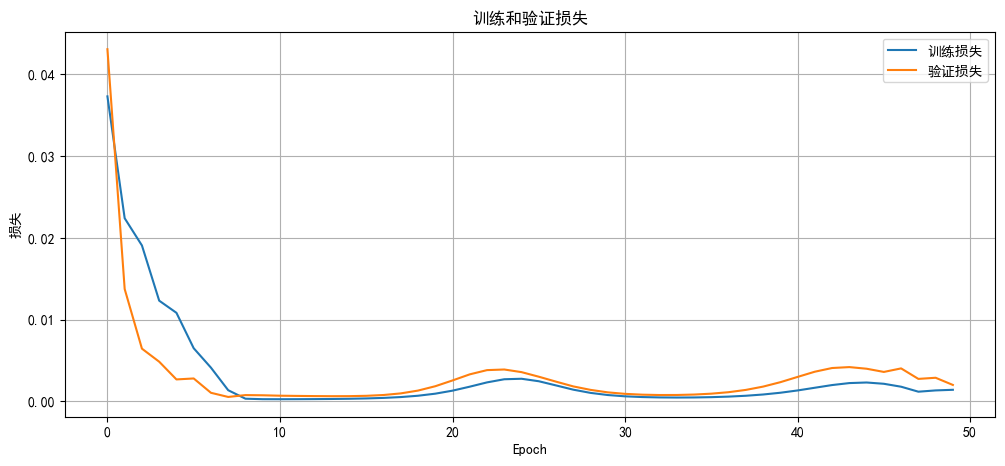

In [ ]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 初始化RNN模型
input_size = X_train.shape[2]  # 特征维度
hidden_size = 128
output_size = 1

model = RNN_(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(model)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

"""
使用MSE作为损失函数
使用Adam优化器
"""

# 训练模型
epochs = 50
batch_size = 64
train_losses = []
val_losses = []

# 计算总批次数
n_batches = len(X_train_tensor) // batch_size

print(f"开始训练，总批次：{n_batches}，总样本数：{len(X_train_tensor)}")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    # 批次训练
    for i in range(0, len(X_train_tensor), batch_size):
        # 获取批次数据
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    """
    分批次训练，每次计算梯度并更新参数
    记录训练损失
    """
    # 计算平均训练损失
    train_loss /= n_batches
    train_losses.append(train_loss)
    
    # 验证
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor.unsqueeze(1))
        val_losses.append(val_loss.item())
    """记录验证损失"""

    # 每10个epoch打印一次损失
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}')

# 绘制训练和验证损失曲线
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练和验证损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()



**模型预测与评估**

In [6]:
# 预测
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_test_pred = model(X_test_tensor).numpy()

# 将预测值转换回原始尺度
# 创建占位符数组
train_pred_full = np.zeros((len(y_train_pred), len(selected_features)))
train_pred_full[:, 3] = y_train_pred.flatten()  # 3是收盘价的索引
train_pred = scaler_train.inverse_transform(train_pred_full)[:, 3]

test_pred_full = np.zeros((len(y_test_pred), len(selected_features)))
test_pred_full[:, 3] = y_test_pred.flatten()
test_pred = scaler_test.inverse_transform(test_pred_full)[:, 3]
"""将预测结果反归一化，得到实际价格"""

# 获取原始收盘价数据
train_close = train_features['Close'].values[time_step:]
test_close = test_features['Close'].values[time_step:]

# 计算RMSE
train_rmse = np.sqrt(mean_squared_error(train_close, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_close, test_pred))
print(f'训练集RMSE: {train_rmse:.4f}')
print(f'测试集RMSE: {test_rmse:.4f}')
"""计算均方根误差(RMSE)，衡量预测值与实际值的偏差"""

# 可视化预测结果
plt.figure(figsize=(14, 7))

训练集RMSE: 1.9196
测试集RMSE: 1.9375


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

**计算并可视化预测收益率**

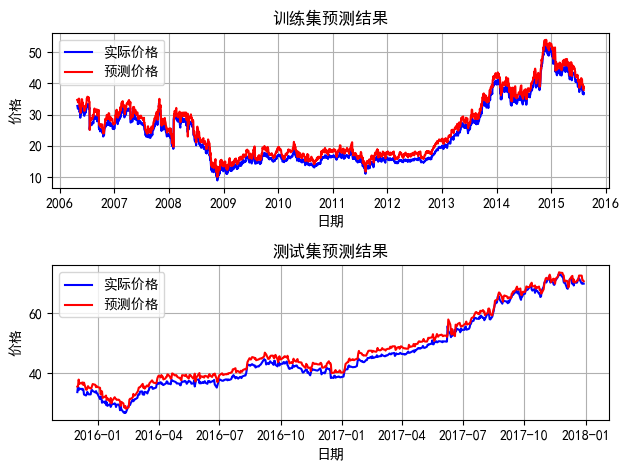

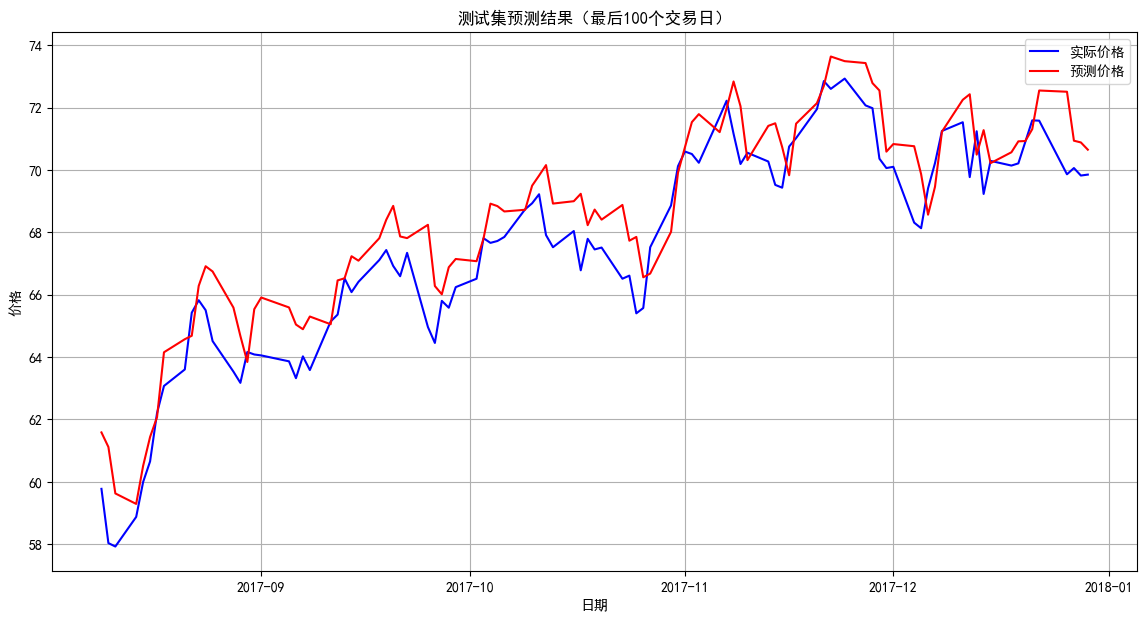

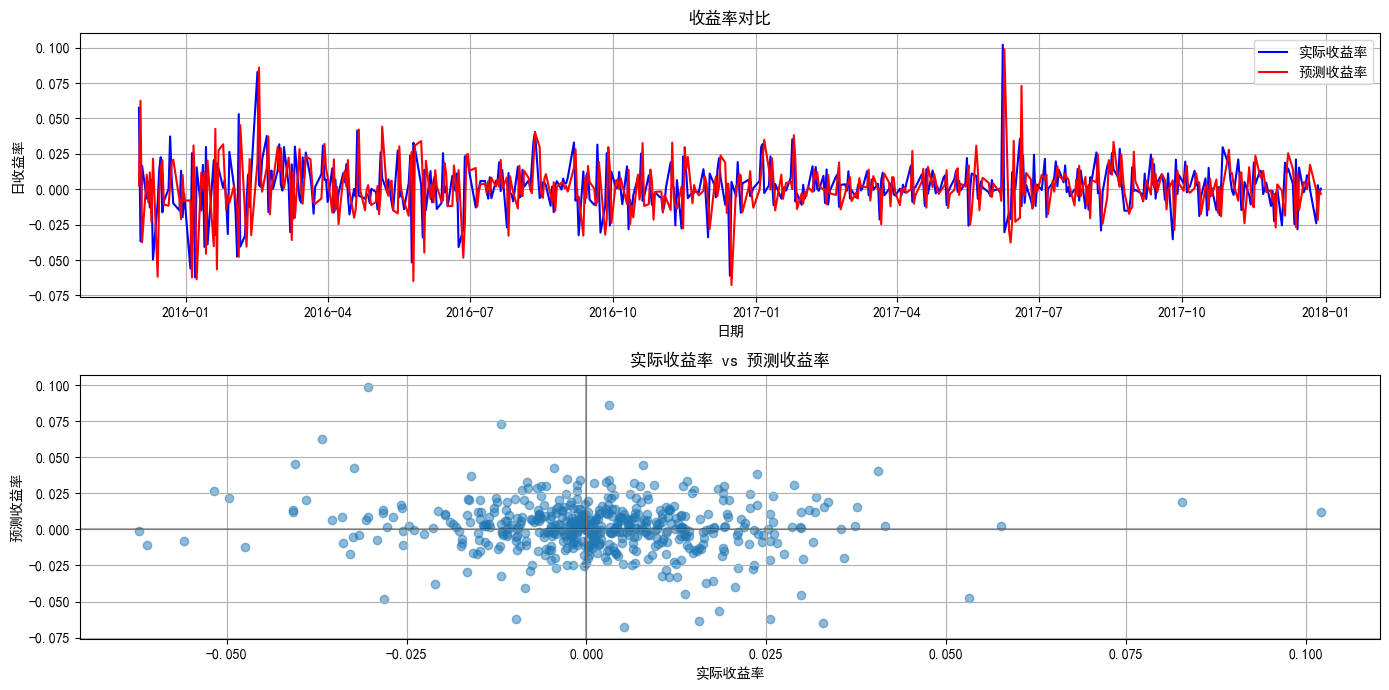

收益率方向准确率: 0.4599 (45.99%)


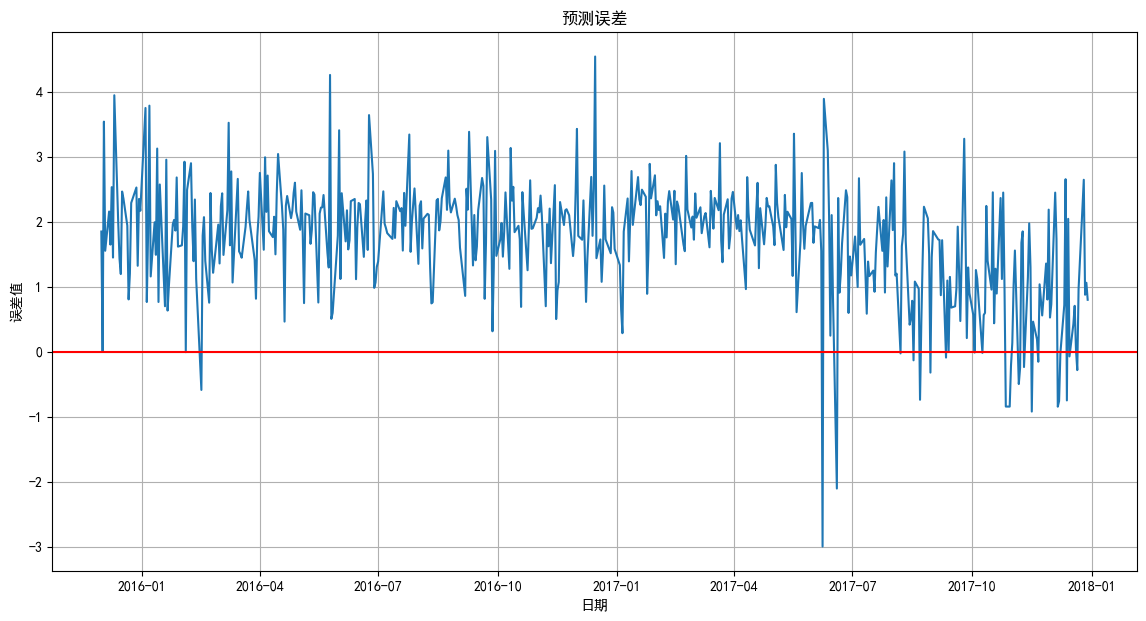

In [ ]:

# 获取日期索引
train_dates = train_features.index[time_step:]
test_dates = test_features.index[time_step:]

# 训练集预测可视化
plt.subplot(2, 1, 1)
plt.plot(train_dates, train_close, 'b-', label='实际价格')
plt.plot(train_dates, train_pred, 'r-', label='预测价格')
plt.title('训练集预测结果')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)

# 测试集预测可视化
plt.subplot(2, 1, 2)
plt.plot(test_dates, test_close, 'b-', label='实际价格')
plt.plot(test_dates, test_pred, 'r-', label='预测价格')
plt.title('测试集预测结果')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 可视化局部放大图
plt.figure(figsize=(14, 7))
# 选择最后100个点进行可视化
plt.plot(test_dates[-100:], test_close[-100:], 'b-', label='实际价格')
plt.plot(test_dates[-100:], test_pred[-100:], 'r-', label='预测价格')
plt.title('测试集预测结果（最后100个交易日）')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()

# 计算收益率
def calculate_returns(prices):
    return np.diff(prices) / prices[:-1]
"""收益率 = (今日收盘价 - 昨日收盘价) / 昨日收盘价"""

actual_returns = calculate_returns(test_close)
pred_returns = calculate_returns(test_pred)

# 可视化收益率对比
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(test_dates[1:], actual_returns, 'b-', label='实际收益率')
plt.plot(test_dates[1:], pred_returns, 'r-', label='预测收益率')
plt.title('收益率对比')
plt.xlabel('日期')
plt.ylabel('日收益率')
plt.legend()
plt.grid(True)

# 收益率散点图
plt.subplot(2, 1, 2)
plt.scatter(actual_returns, pred_returns, alpha=0.5)
plt.title('实际收益率 vs 预测收益率')
plt.xlabel('实际收益率')
plt.ylabel('预测收益率')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True)

plt.tight_layout()
plt.show()

# 计算方向准确率（预测收益率正负是否与实际一致）
direction_accuracy = np.mean((np.sign(pred_returns) == np.sign(actual_returns)).astype(int))
print(f'收益率方向准确率: {direction_accuracy:.4f} ({direction_accuracy*100:.2f}%)')

# 绘制预测与实际的差异
plt.figure(figsize=(14, 7))
prediction_error = test_pred - test_close
plt.plot(test_dates, prediction_error)
plt.title('预测误差')
plt.xlabel('日期')
plt.ylabel('误差值')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()

**模拟简单交易策略**

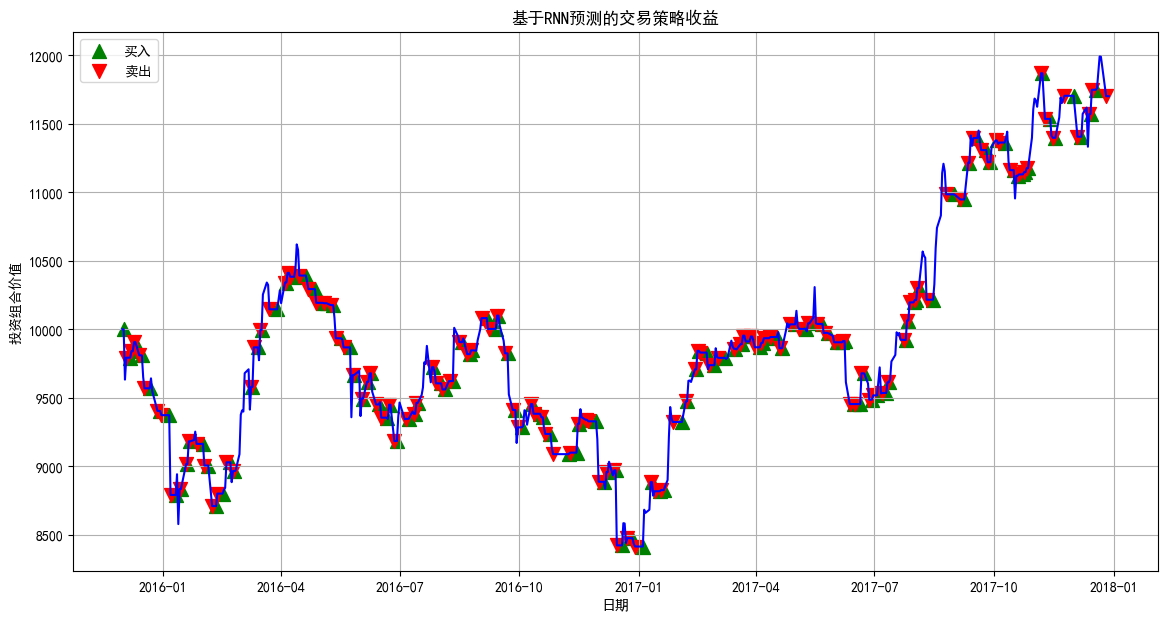

策略最终资金: 11702.50
策略收益率: 0.1703 (17.03%)
买入持有收益率: 1.0721 (107.21%)


In [ ]:
# 模拟简单交易策略
initial_capital = 10000
capital = initial_capital
positions = 0
portfolio_values = [initial_capital]
trades = []

# 根据收益率预测进行买卖
for i in range(1, len(test_close)):
    if i >= len(pred_returns):
        break
        
    current_price = test_close[i]
    pred_return = pred_returns[i-1]  # 使用前一天预测的下一天收益率
    
    # 如果预测收益率为正，则买入
    if pred_return > 0 and positions == 0:
        positions = capital / current_price
        capital = 0
        trades.append((test_dates[i], current_price, 'BUY'))
    # 如果预测收益率为负，则卖出
    elif pred_return < 0 and positions > 0:
        capital = positions * current_price
        positions = 0
        trades.append((test_dates[i], current_price, 'SELL'))
    """
    简单交易策略：
    1.当预测次日收益率为正时买入
    2.当预测次日收益率为负时卖出
    """
    # 记录当前价值
    current_value = capital + positions * current_price
    portfolio_values.append(current_value)

# 绘制策略价值变化
plt.figure(figsize=(14, 7))
plt.plot(test_dates[:len(portfolio_values)], portfolio_values, 'b-')
plt.title('基于RNN预测的交易策略收益')
plt.xlabel('日期')
plt.ylabel('投资组合价值')
plt.grid(True)

# 标注买卖点
buy_dates = [date for date, _, action in trades if action == 'BUY']
sell_dates = [date for date, _, action in trades if action == 'SELL']
buy_values = [portfolio_values[list(test_dates[:len(portfolio_values)]).index(date)] for date in buy_dates]
sell_values = [portfolio_values[list(test_dates[:len(portfolio_values)]).index(date)] for date in sell_dates]

plt.scatter(buy_dates, buy_values, color='green', marker='^', s=100, label='买入')
plt.scatter(sell_dates, sell_values, color='red', marker='v', s=100, label='卖出')
plt.legend()
plt.show()

# 计算策略收益率
strategy_return = (portfolio_values[-1] - initial_capital) / initial_capital
buy_hold_return = (test_close[-1] - test_close[0]) / test_close[0]
"""计算策略收益率并与买入持有策略比较"""

print(f'策略最终资金: {portfolio_values[-1]:.2f}')
print(f'策略收益率: {strategy_return:.4f} ({strategy_return*100:.2f}%)')
print(f'买入持有收益率: {buy_hold_return:.4f} ({buy_hold_return*100:.2f}%)')

# 第一部分 基础练习

## 基础RNN构建与序列预测

使用PyTorch构建一个简单的RNN模型，训练其对正弦波序列进行单步预测，并可视化预测效果。

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. 数据生成与预处理
time_steps = 1000
timesteps = np.linspace(0, 10*np.pi, time_steps)
data = np.sin(timesteps).reshape(-1, 1)  # 正弦波序列

# 滑动窗口构造输入-输出对
def create_sequences(data, window_size=20):
    X, y = [], []
    for i in range(len(data)-window_size-1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(data)
X_train, y_train = X[:700], y[:700]  # 训练集（前70%）
X_test, y_test = X[700:], y[700:]    # 测试集（后30%）

# 转换为张量
X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)

**模型定义**

参考课件中RNN模型的定义，构建一个简单的RNN模型。不可以使用nn.RNN等封装好的RNN模型，必须自己实现RNN的前向传播。模型输入为一个序列，输出为该序列的下一个值。


In [14]:
# 2. 模型定义
# TODO 以下代码重要
class SimpleRNN(nn.Module):
    ################################################################
    # TODO: 定义一个简单的RNN模型
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, input_):
        batch_size = input_.size(0) # 获取批次大小
        hidden = self.init_hidden(batch_size)
        for t in range(input_.size(1)):
            input_t = input_[:, t, :]
            combined = torch.cat((input_t, hidden), dim = 1)
            hidden = self.i2h(combined)
            hidden = self.tanh(hidden)
        output = self.h2o(hidden)
        return output
    
    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)
    ################################################################

**模型训练**

In [ ]:
##########################
# TODO: 训练模型，构建模型、损失函数和优化器
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
##############################

# 3. 训练循环
epochs = 500
for epoch in range(epochs):
    ##########################
    # TODO: 前向传播、计算损失、反向传播和优化
    optimizer.zero_grad() # 清零梯度
    output = model(X_train) # 前向传播
    loss = criterion(output, y_train)
    loss.backward() # 反向传播计算梯度
    optimizer.step() # 更新参数
    ##############################
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.3928
Epoch 20, Loss: 0.2419
Epoch 30, Loss: 0.0278
Epoch 40, Loss: 0.0172
Epoch 50, Loss: 0.0167
Epoch 60, Loss: 0.0113
Epoch 70, Loss: 0.0075
Epoch 80, Loss: 0.0052
Epoch 90, Loss: 0.0038
Epoch 100, Loss: 0.0028
Epoch 110, Loss: 0.0020
Epoch 120, Loss: 0.0014
Epoch 130, Loss: 0.0010
Epoch 140, Loss: 0.0008
Epoch 150, Loss: 0.0008
Epoch 160, Loss: 0.0007
Epoch 170, Loss: 0.0007
Epoch 180, Loss: 0.0006
Epoch 190, Loss: 0.0006
Epoch 200, Loss: 0.0006
Epoch 210, Loss: 0.0006
Epoch 220, Loss: 0.0005
Epoch 230, Loss: 0.0005
Epoch 240, Loss: 0.0005
Epoch 250, Loss: 0.0005
Epoch 260, Loss: 0.0005
Epoch 270, Loss: 0.0004
Epoch 280, Loss: 0.0004
Epoch 290, Loss: 0.0004
Epoch 300, Loss: 0.0004
Epoch 310, Loss: 0.0004
Epoch 320, Loss: 0.0004
Epoch 330, Loss: 0.0003
Epoch 340, Loss: 0.0003
Epoch 350, Loss: 0.0003
Epoch 360, Loss: 0.0003
Epoch 370, Loss: 0.0003
Epoch 380, Loss: 0.0003
Epoch 390, Loss: 0.0003
Epoch 400, Loss: 0.0002
Epoch 410, Loss: 0.0002
Epoch 420, Loss: 0.0002
E

**预测与可视化**

In [ ]:
# 4. 预测与可视化
with torch.no_grad():
    test_pred = model(torch.Tensor(X_test))
    plt.plot(y_test, label='True')
    plt.plot(test_pred.numpy(), label='Predicted')
    plt.legend()
    plt.show()

# 第二部分 进阶练习

## **2.1** RNN模型的进阶应用

**任务描述**

在本次作业中，我们将使用RNN模型进行文本分类任务。

使用词性标注(POS tagging)数据集，位于data文件夹中。该数据集包含了不同词性标签的单词集合，每个文件对应一种词性类别。

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
torch.manual_seed(0)
np.random.seed(0)

**读取数据并划分数据集**

In [30]:
def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

**数据准备和预处理**

字符串编码

In [31]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [32]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [33]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [34]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    # TODO: 创建一个数据加载器，随机选择batch_size个样本
    indices = np.random.choice(len(X_), batch_size, replace = False)
    for idx in indices:
        name, nat = X_[idx], y_[idx]
        to_ret.append((name_rep(name), nat_rep(nat)))
    return to_ret

**RNN网络搭建**

参考PPT课件，搭建一个RNN网络。不可以使用nn.RNN、nn.LSTM或nn.GRU等模块。

In [35]:
class RNN_net(nn.Module):
    # TODO: 定义一个RNN模型
    def __init__(self, embedding_dim, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        # 不用self.embedding = nn.Embedding(n_letters, embedding_dim)，因为dataloader已经转换为one-hot编码了，不用再嵌入
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input_, hidden):
        # input_ shape: (seq_len, 1, n_letters)
        # hidden shape: (1, hidden_size)
        combined = torch.cat((input_, hidden), dim = 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

**模型训练**

In [36]:
# function to train the data

def train_step(net, opt, criterion, batch_size):
    total_loss = 0
    # TODO: 训练一个batch的数据      
    data = dataloader(batch_size, X_train, y_train)
    for name, nat in data:
        hidden = net.init_hidden()
        opt.zero_grad() # 一定要有这行！
        for i in range(name.size(0)): output, hidden = net(name[i], hidden)
        loss = criterion(output, nat)
        loss.backward()
        opt.step()
        total_loss += loss.item()

    return total_loss/batch_size

In [ ]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):
    # TODO: 训练模型
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum) # 由于有momentum，所以用SGD
    criterion = nn.NLLLoss() # 多分类，用负对数似然损失
    for step in range(steps):
        loss = train_step(net, opt = optimizer, criterion = criterion, batch_size = batch_size)
        if (step + 1) % freq == 0 or step == steps - 1:
            # clear_output(wait = True)
            print(f"Step {step + 1}/{steps}, Loss: {loss:.4f}")


In [45]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)

Step 5/100, Loss: 1.8905
Step 10/100, Loss: 1.7707
Step 15/100, Loss: 1.6777
Step 20/100, Loss: 1.4427
Step 25/100, Loss: 1.4871
Step 30/100, Loss: 1.3522
Step 35/100, Loss: 1.3001
Step 40/100, Loss: 1.1878
Step 45/100, Loss: 1.2873
Step 50/100, Loss: 1.2264
Step 55/100, Loss: 1.1436
Step 60/100, Loss: 1.0996
Step 65/100, Loss: 0.9576
Step 70/100, Loss: 0.9626
Step 75/100, Loss: 0.9108
Step 80/100, Loss: 0.8261
Step 85/100, Loss: 0.9013
Step 90/100, Loss: 0.8694
Step 95/100, Loss: 1.0286
Step 100/100, Loss: 0.8000


**模型评估**

In [46]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [56]:
#create a function to evaluate model

def eval_test(net):
     # TODO: 评估模型在测试集上的准确率
     total_correct = 0
     total_samples = len(X_test)
     for name, nat in zip(X_test, y_test):
         output = infer(net, name)
         pred = output.argmax().item()
         if pred == nat_rep(nat): total_correct += 1
     accuracy = total_correct / total_samples
     return accuracy

In [57]:
#create a function to evaluate model

def eval_train(net):
    # TODO: 评估模型在训练集上的准确率
    total_correct = 0
    total_samples = len(X_train)
    for name, nat in zip(X_train, y_train):
        output = infer(net, name)
        pred = output.argmax().item()
        if pred == nat_rep(nat): total_correct += 1
    accuracy = total_correct / total_samples
    return accuracy

In [58]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.682
test set accuracy:0.6883
